### WIP. Julia code is working correctly.

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftn, ifftn, dct, idct, dctn, idctn
from scipy.io import wavfile
from scipy.ndimage.filters import uniform_filter1d
import cvxpy as cp

Text(0.5, 0, 'frequency domain')

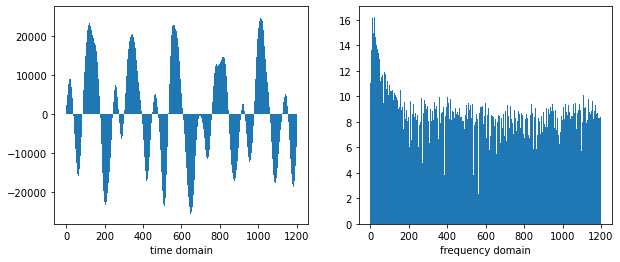

In [99]:
N = 1200
sound = wavfile.read("piano.wav")[1][:N]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(range(N), sound, width=1)
ax[0].set_xlabel("time domain")
ax[1].bar(range(N), np.log(np.abs(dctn(sound))), width=1)
ax[1].set_xlabel("frequency domain")

<BarContainer object of 1200 artists>

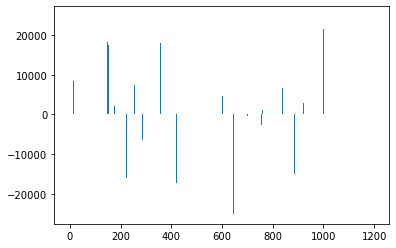

In [101]:
sample_density = 0.05
sampling_mat = np.random.rand(N) < sample_density
sampled_sound = sound * sampling_mat

plt.bar(range(N), sampled_sound, width=1)

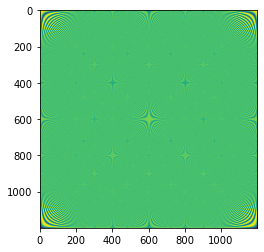

In [111]:
IDCT = dctn(np.eye(N), axes=0)
plt.imshow(np.log1p(np.abs(IDCT)))

In [103]:
sampled_sound.size

1200

In [104]:
# Tolerance (WAV bit depth is 2**16)
epsilon = .1 * 2**16

# Decision variable is Fourier transform coefs
dct_pred = cp.Variable(sampled_sound.shape)

# L1 norm
objective = cp.Minimize(cp.norm(dct_pred, 1))

constraints = []
for i, tf in np.ndenumerate(sampling_mat):
    if tf:
        # IDCT of the result must agree with sampled pixels
        constraints.append( (IDCT @ dct_pred)[i] - epsilon <= sampled_sound[i])
        constraints.append( (IDCT @ dct_pred)[i] + epsilon >= sampled_sound[i])

# Solve
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 14 09:34:03 AM: Your problem has 1200 variables, 148 constraints, and 0 parameters.
(CVXPY) Jul 14 09:34:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 09:34:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 09:34:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 09:34:03 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 14 09:34:03 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

17044.2063070848

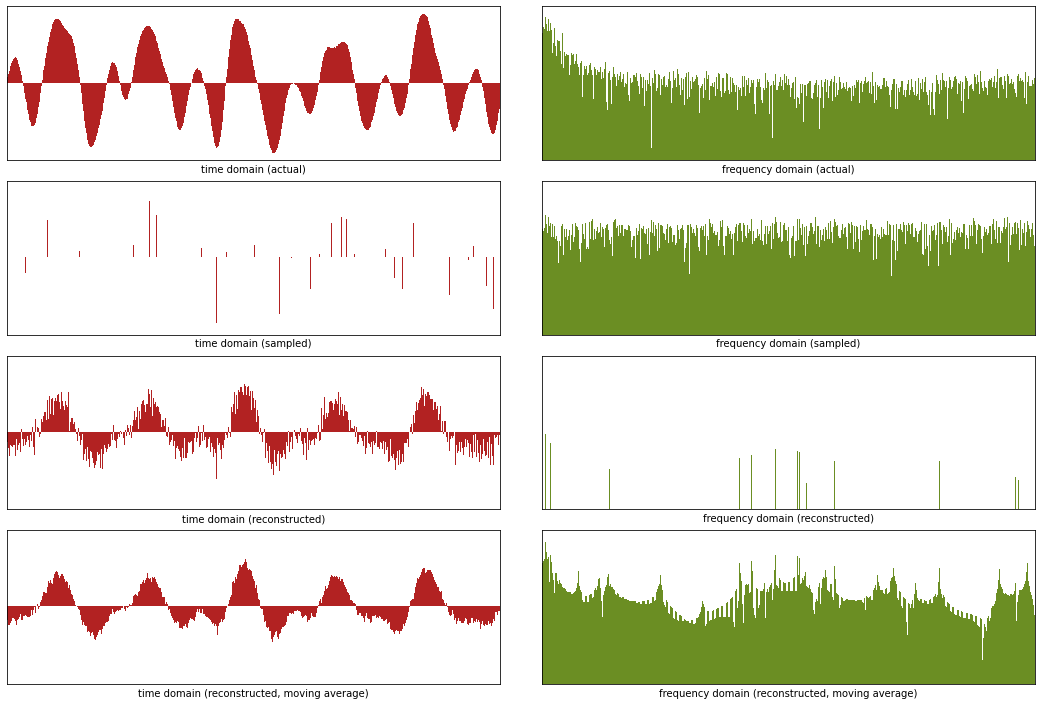

In [129]:
reconstructed_signal = IDCT @ dct_pred.value

fig, ax = plt.subplots(4, 2, figsize=(15, 10), sharey="col", sharex="all")
plt.tight_layout()

for row in ax:
    for a in row:
        a.set_xlim((0.5, N-0.5))
        a.tick_params(axis="both", which="both", left=False, bottom=False, labelbottom=False, labelleft=False)
    
ax[0, 0].bar(range(N), sound, width=1, color="firebrick")
ax[0, 0].set_xlabel("time domain (actual)")
ax[0, 1].bar(range(N), np.log1p(np.abs(dctn(sound))), width=1, color="olivedrab")
ax[0, 1].set_xlabel("frequency domain (actual)")

ax[1, 0].bar(range(N), sampled_sound, width=1, color="firebrick")
ax[1, 0].set_xlabel("time domain (sampled)")
ax[1, 1].bar(range(N), np.log1p(np.abs(dctn(sampled_sound))), width=1, color="olivedrab")
ax[1, 1].set_xlabel("frequency domain (sampled)")

ax[2, 0].bar(range(N), reconstructed_signal, width=1, color="firebrick")
ax[2, 0].set_xlabel("time domain (reconstructed)")
ax[2, 1].bar(range(N), np.log1p(np.abs(dct_pred.value)), width=1, color="olivedrab")
ax[2, 1].set_xlabel("frequency domain (reconstructed)")

moving_avg = uniform_filter1d(reconstructed_signal, size=5)
ax[3, 0].bar(range(N), moving_avg, width=1, color="firebrick")
ax[3, 0].set_xlabel("time domain (reconstructed, moving average)")
ax[3, 1].bar(range(N), np.log1p(np.abs(dctn(reconstructed_signal))), width=1, color="olivedrab")
ax[3, 1].set_xlabel("frequency domain (reconstructed, moving average)")

plt.savefig("sound-reconstruction.pdf")

In [79]:
def zero_one(arr):
    res = np.log1p(abs(arr))
    res /= np.max(res)
    return res

def plot_rgb(img):
    zo = zero_one(img)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, c in enumerate("red green blue".split()):
        ax[i].set_title(c)
        ax[i].imshow(zo[:, :, i])

In [3]:
ballot = plt.imread("ballot.tif", format="tif").astype(int)
ballot_fft = fftn(ballot, axes=(0,1))

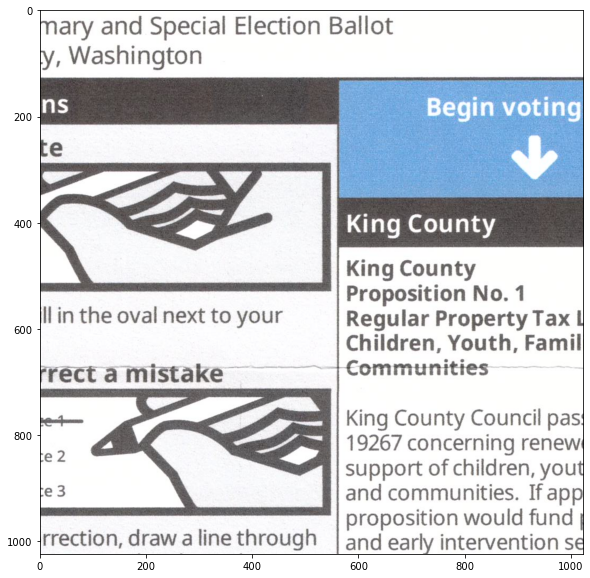

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(ballot)

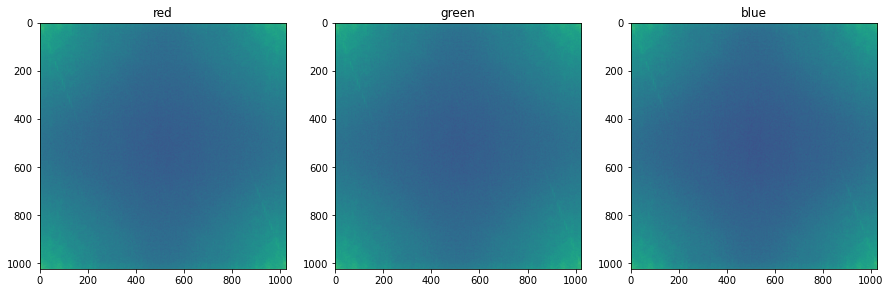

In [5]:
plot_rgb(ballot_fft)

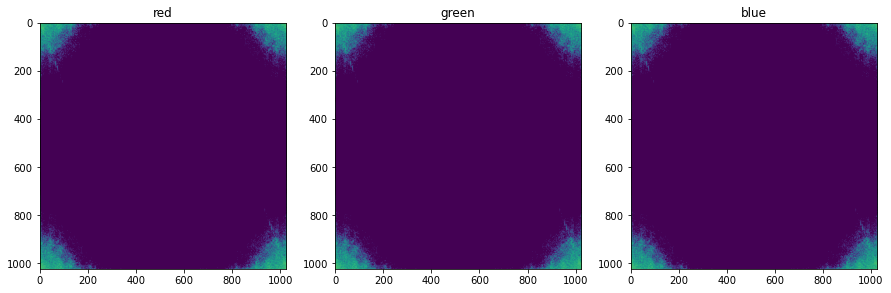

In [6]:
ratio = 20
n_keep = np.prod(ballot.shape) // ratio

# np.argpartition(np.abs(ballot_fft).flatten(), kth=range(n_keep))
keep_idx = np.argsort(np.abs(ballot_fft).flatten())[-n_keep:]

ballot_comp = np.zeros(ballot.size, dtype=complex)
ballot_comp[keep_idx] = ballot_fft.flatten()[keep_idx]
ballot_comp.shape = ballot.shape

plot_rgb(ballot_comp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


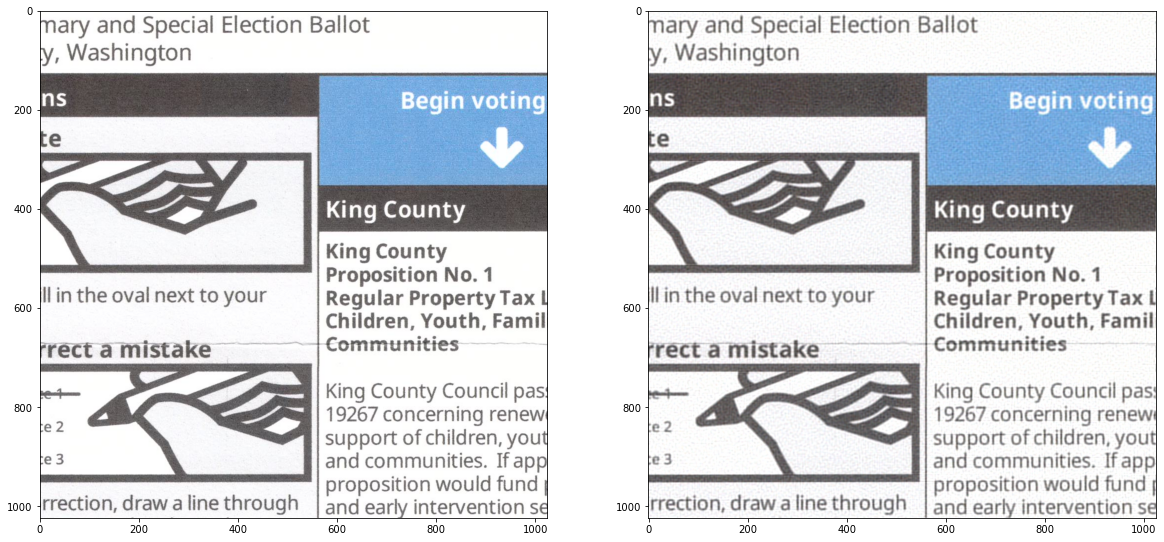

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(ballot)
ax[1].imshow(ifftn(ballot_comp, axes=(0, 1)).real.astype(int))

## Denoising

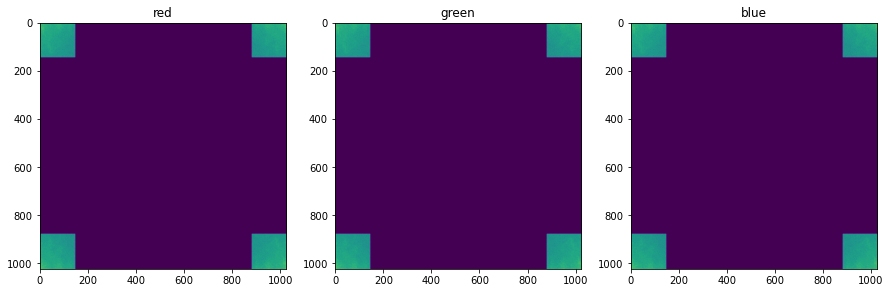

In [8]:
ballot_denoised = np.array(ballot_fft)
rat = 7
n_trim0, n_trim1 = ballot_denoised.shape[0] // rat, ballot_denoised.shape[1] // rat

ballot_denoised[n_trim0:-n_trim0, :, : ] = 0
ballot_denoised[:, n_trim1:-n_trim1, : ] = 0

plot_rgb(ballot_denoised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


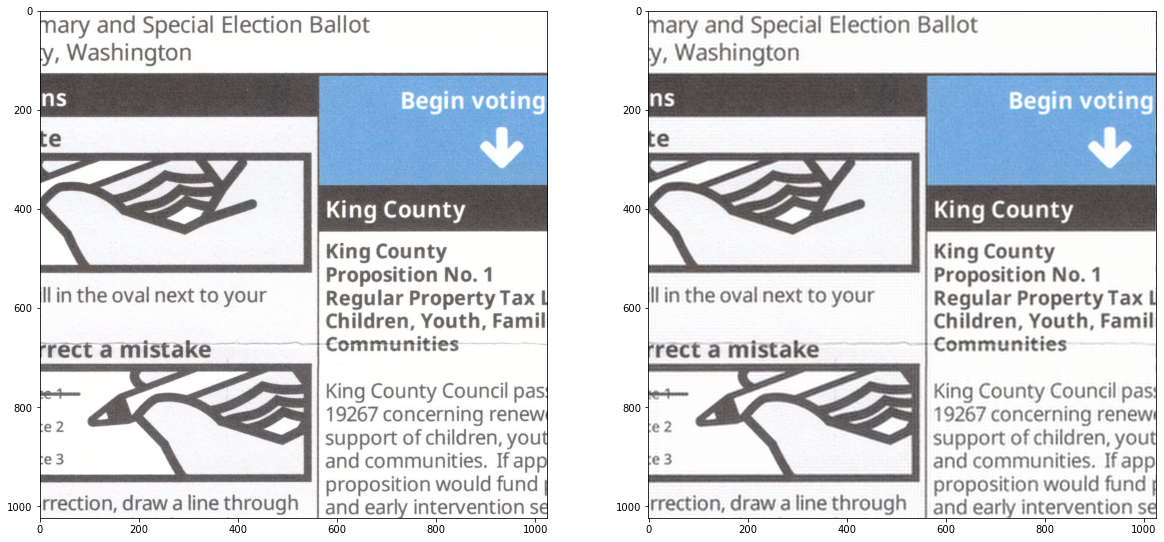

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(ballot)
ax[1].imshow(ifftn(ballot_denoised, axes=(0,1)).real.astype(int))

## Compressed sensing

In [5]:
# Just do one channel
img = plt.imread("building.tif").astype(int)[100:150, 25:100, 0]

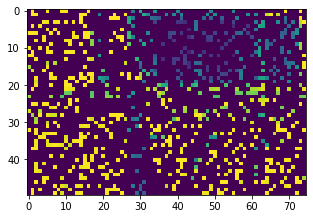

In [6]:
# Percentage of pixels we were allowed to sample
sampling_density = 0.2

# Boolean index of where samples are taken
sampling_matrix = np.random.rand(*np.zeros_like(img).shape) < sampling_density

# Image with sampled pixels only
sampled_image = sampling_matrix * img

plt.figure(figsize=(5, 5))
plt.imshow(sampled_image, vmin=0, vmax=255)

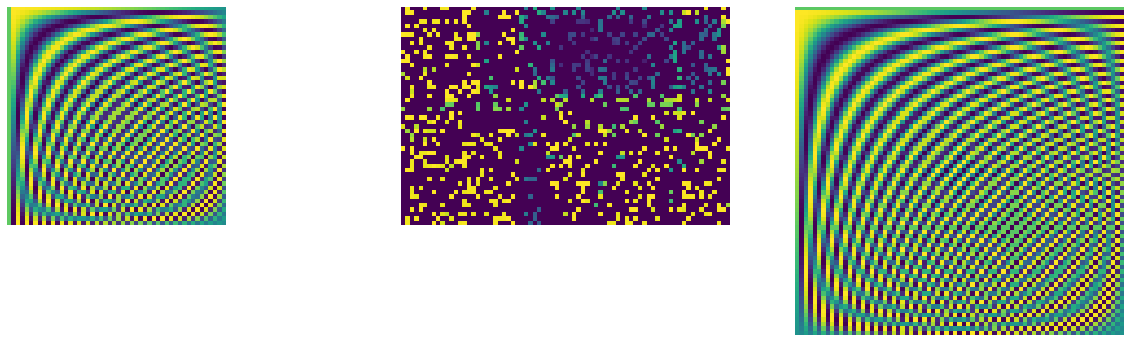

In [7]:
# Get the IFFT matrix with this image's dimensions
# Complex part is approx. 0
IDCTx = idctn(np.eye(sampled_image.shape[0]), axes=0)
IDCTy = idctn(np.eye(sampled_image.shape[1]), axes=1)

fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex="all", sharey="all")
[ax[i].set_axis_off() for i in range(3)]
ax[0].imshow(IDCTx)
ax[1].imshow(sampled_image, vmin=0, vmax=255)
ax[2].imshow(IDCTy)

In [ ]:
# Decision variable is Fourier transform coefs
dct_pred = cp.Variable(sampled_image.shape)

# L1 norm
objective = cp.Minimize(cp.norm(dct_pred, 1))
#                         + cp.sum_squares((IDCTx @ dct_pred @ IDCTy)[sampling_matrix] - sampled_image[sampling_matrix]))

constraints = []
for (i, j), tf in np.ndenumerate(sampling_matrix):
    if tf:
        # IDCT of the result must agree with sampled pixels
        constraints.append( (IDCTx @ dct_pred @ IDCTy)[i, j] == sampled_image[i, j])

# Solve
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 14 08:48:56 AM: Your problem has 3750 variables, 747 constraints, and 0 parameters.
(CVXPY) Jul 14 08:48:56 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 08:48:56 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 08:48:56 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 08:48:56 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 14 08:48:56 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

Text(0.5, 1.0, 'best guess')

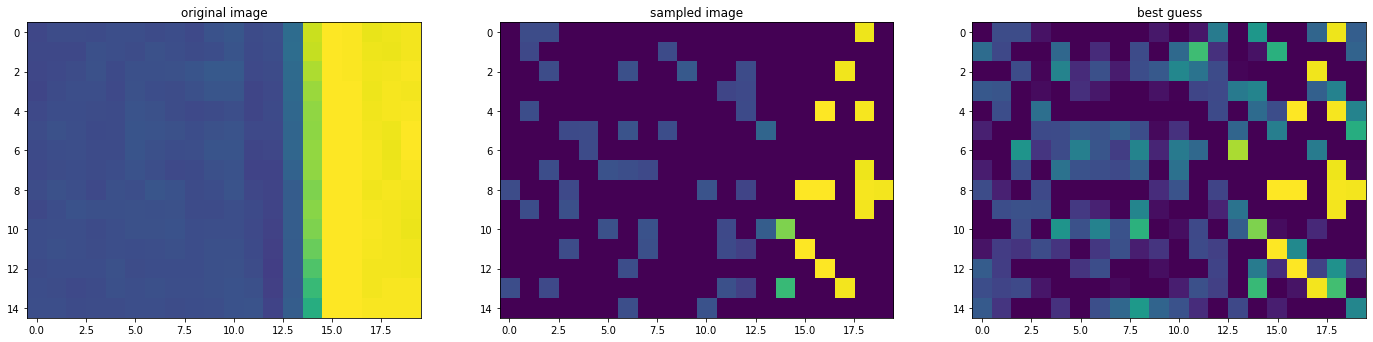

In [50]:
# Or ifftn(fft_pred.value), but for some reason that yields a different result.
predicted_img = idctn(dct_pred.value)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(img, vmin=0, vmax=255)
ax[0].set_title("original image")
ax[1].imshow(sampled_image, vmin=0, vmax=255)
ax[1].set_title("sampled image")
ax[2].imshow(predicted_img, vmin=0, vmax=255)
ax[2].set_title("best guess")

In [46]:
np.count_nonzero(dct_pred.value.round(2))

77

In [14]:
building = plt.imread("building.tif", format="tif").astype(int)[100:300, :200, :]

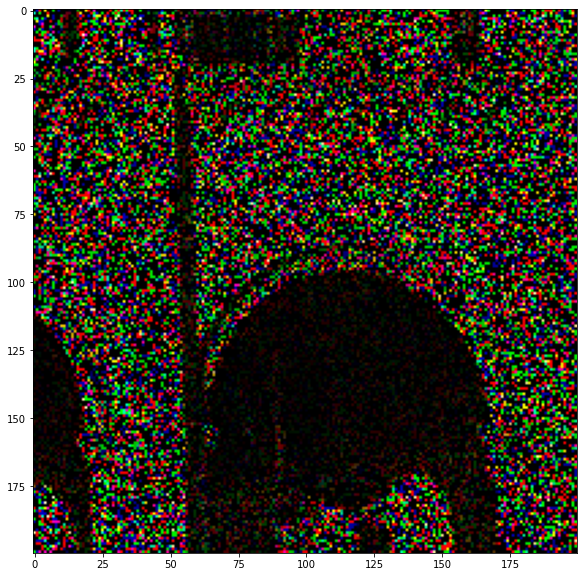

In [15]:
sampling_density = 0.2
sampling_matrix = np.random.rand(*building.shape) < sampling_density
sampled_image = sampling_matrix * building
# Vector form is building[sampling_matrix]

plt.figure(figsize=(10, 10))
plt.imshow(sampled_image)

In [16]:
res_fft_red = cp.Variable(np.zeros_like(building).shape[:2])
res_fft_blu = cp.Variable(np.zeros_like(building).shape[:2])
res_fft_grn = cp.Variable(np.zeros_like(building).shape[:2])

IDCT = idct(np.eye(*building.shape)).real
res = []
    
for ch, var in enumerate([res_fft_red, res_fft_blu, res_fft_grn][:1]):
    # L1 norm
    objective = cp.Minimize(cp.norm(var, 1))

    constraints = []
    for (i, j), tf in np.ndenumerate(sampling_matrix[:, :, ch]):
        if tf:
            # IFFT of the result must agree with sampled pixels
            constraints.append( (IDCT @ var)[i, j] == sampled_image[i, j, ch] )

    # Solve
    prob = cp.Problem(objective, constraints)
    res.append(prob.solve(verbose=True))

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 12 06:55:17 PM: Your problem has 40000 variables, 8146 constraints, and 0 parameters.
(CVXPY) Jul 12 06:55:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 06:55:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 12 06:55:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 12 06:55:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 12 06:55:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

In [20]:
predicted_fft = np.stack([i.value for i in (res_fft_red, res_fft_blu, res_fft_grn), axis=-1)
predicted_img = np.stack([IDCT @ i.value for i in (res_fft_red, res_fft_blu, res_fft_grn)], axis=-1)
plot_rgb(predicted_fft)

SyntaxError: invalid syntax (<ipython-input-20-4ddbcf1b631a>, line 1)

In [24]:
res

[inf]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].imshow(building)
ax[0].set_title("original image")
ax[1].imshow(sampled_image)
ax[1].set_title("sampled image")
ax[2].imshow(predicted_img.real.astype(int))
ax[2].set_title("best guess")

In [ ]:
np.mean(predicted_fft > 1e-4)

In [ ]:
IFFT = ifft2(np.eye(512, 512)).real

In [ ]:
g = np.random.rand(10,10)

In [ ]:
FFT = fft2(np.eye(10))

In [ ]:
plt.imshow(np.abs(fftn(g)))

In [ ]:
plt.imshow(np.abs(FFT @ g))

In [ ]:
IFFT @ res_fft_red.value

In [ ]:
IFFT = ifftn(np.eye(*np.zeros_like(building).shape[:2])).real


In [ ]:
building[:, :, 0][sampling_matrix[:, :, 0]]

In [ ]:
(IFFT @ res_fft_red.value)[sampling_matrix[:, :, 0]]

In [ ]:
np.size(building[:, :, 0][sampling_matrix[:, :, 0]])

In [ ]:
(IFFT @ res_fft_red)[sampling_matrix[:, :, 0]] == building[:, :, 0][sampling_matrix[:, :, 0]]

In [ ]:
res_fft_red.value

In [ ]:
ifftn(predicted_fft, axes=(0,1)).real[:, :, 0]

In [ ]:
np.abs(ifftn(np.eye(*np.zeros_like(building).shape[:2])).imag).sum()